<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/udemy_pytorch_08_PyTorchPaperReplicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn an ML research paper into usable code.

In this notebook, we're going to be replicating the [Vision Transformer (ViT) architecture paper](https://arxiv.org/abs/2010.11929) in PyTorch.

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/08_pytorch_paper_replicating.ipynb

In [2]:
path = '/usr/local/share/jupyter/nbextensions/google.colab'
!cp -r {path}/* .
!rm -r {path}
!ln -s /content {path}
# change base tag
from google.colab.output import eval_js
def change_base_url():
  eval_js("""
  var base = document.createElement('base')
  base.href = 'https://localhost:8080/nbextensions/google.colab/'
  document.head.prepend(base)
  """)
# make it run automatically in every cell
get_ipython().events.register('pre_run_cell', change_base_url)

In [3]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [4]:
# 0. Get setup
# import code we've already created and libraries.
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/data . # keep the data dir
    !mv pytorch-deep-learning/images . # keep the images dir
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    # Now that we've downloaded everything, import the modules we need:
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3416, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 3416 (delta 47), reused 92 (delta 39), pack-reused 3302
Receiving objects: 100% (3416/3416), 643.45 MiB | 39.79 MiB/s, done.
Resolving deltas: 100% (1954/1954), done.
Updating files: 100% (222/222), done.


In [5]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from helper_functions import plot_decision_boundary, plot_predictions, pred_and_plot_image, set_seeds
# Using my own download_data below, because it's nicer and re-uses the data from github

## 1. Get Data

Namely, the same mini pizza/steak/sushi data we've been using with CNNs.

In [7]:
%%writefile download_data.py
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination
    zipfile_path = (data_path / destination).with_suffix('.zip')

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        print(f'zipfile_path: {zipfile_path}')
        if not zipfile_path.is_file():
          with open(zipfile_path, "wb") as f:
              request = requests.get(source)
              print("Downloading data...")
              f.write(request.content)

    # Unzip pizza, steak, sushi data
    if zipfile_path.is_file():
      with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
          print("Unzipping data...") 
          zip_ref.extractall(image_path)

      # Remove .zip file
      if remove_source:
          os.remove(zipfile_path)
    
    return image_path

Writing download_data.py


In [8]:
from download_data import download_data
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi",
                           remove_source=False)
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
zipfile_path: data/pizza_steak_sushi.zip
Unzipping data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and Dataloaders

# New Section

In [9]:
BATCH_SIZE=32
IMG_SIZE=224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [10]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, len(train_dataloader), test_dataloader, len(test_dataloader), class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f6d05f66430>,
 8,
 3,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always... visualize! Visualize! VISUALIZE!

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(test_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

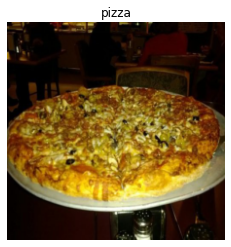

In [12]:
# Plot the demo image
import matplotlib.pyplot as plt

def show_image(image, label=None):
  plt.imshow(image.squeeze().permute(1, 2, 0))
  if label is not None:
    plt.title(class_names[label])
  plt.axis(False)

show_image(image, label)

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating. 

So in order to make it more understandable, we can break it down into smaller pieces. 

* **Inputs** - What goes into the model? (In our case, batches of image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT overview: Pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training
* Text

#### Figure 1
![Figure 1](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-figure-1-architecture-overview.png)


* Embedding - learnable representation (start with random numbers and improve them over time)

* MLP - multilayer perceptron (neural network with multiple layers), for classification

#### Four equations
![Four equestions](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-four-equations.png)

#### Table 1
![Table 1](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png)


$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E}_{;} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

### Section 3.1 describes the various equations:

An overview of the model is depicted in Figure 1. 

**Equation 1:**
The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.


In pseudocode:

```python
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] +
 [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

```python
MSA_layer = Compose([
  LayerNorm(),
  MultiheadAttention()
])

# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

```python
# Equation 4
y = linear_layer(LN_layer(x_output_MLP_block))
```


### Table 1

![Different scale ViT models](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png)

* ViT-Base, ViT-Large, ViT-Huge are all different sizes of the same model architecture (different hyperparameters, same architecture).
* Layers - the number of transformer encoder layers (blocks)
* Hidden Size $D$ - the embedding size throughout the architecture.
* MLP Size - number of hidden units/neurons in the MLP
* Heads - number of multi-head self-attention (`embed_dim` in the [PyTorch module](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html))


torch.Size([3, 224, 224])

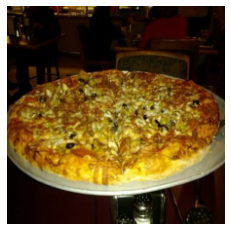

In [13]:
show_image(image)
image.shape

w:224 h:224


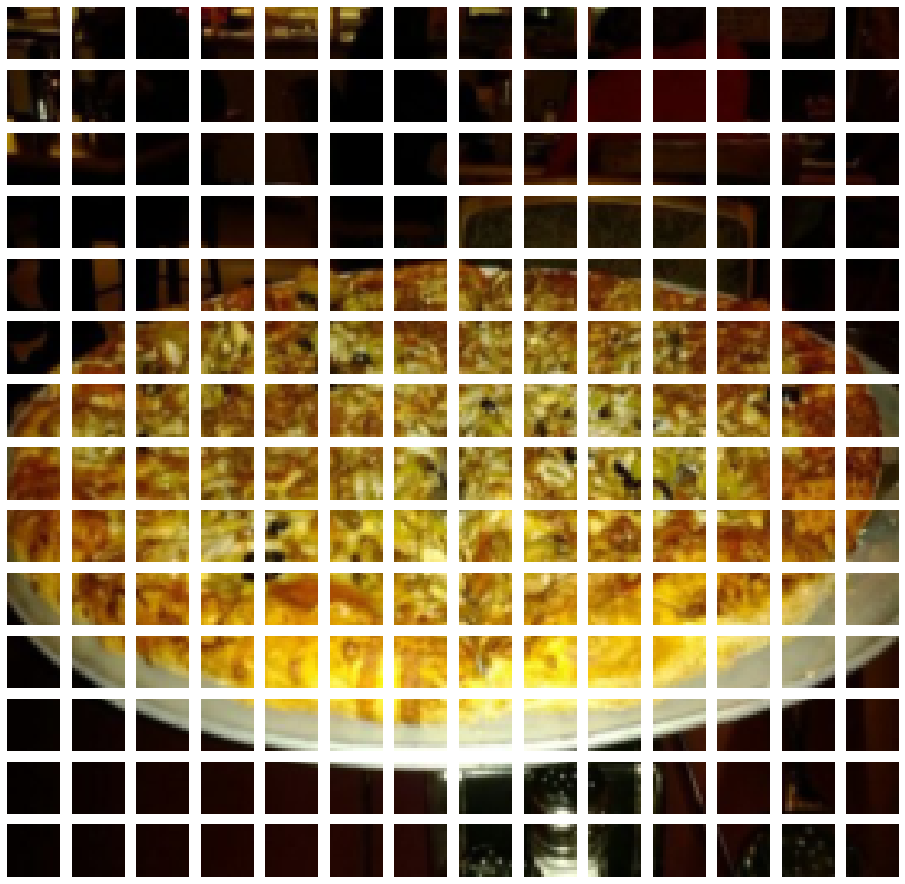

In [14]:
# Gavin's attempt!

from torchvision.transforms.functional import crop
PATCH_SIZE = 16
patch_size = 16
channels, w, h = image.shape
print(f'w:{w} h:{h}')
columns = int(w / PATCH_SIZE)
rows = int(h / PATCH_SIZE)
patches = []
for column in range(columns):
  for row in range(rows):    
    patch = crop(image, column * PATCH_SIZE, row * PATCH_SIZE, PATCH_SIZE, PATCH_SIZE)
    patches.append(patch)

fig = plt.figure(figsize=(patch_size, patch_size))
fig.tight_layout(h_pad=0, w_pad=0)
for i, patch in enumerate(patches):
  fig.add_subplot(rows, columns, i + 1)
  show_image(patch)


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> H,W,C
* Output shape (for equation 1):

**Equation 1:**
The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height * width * color channels)
* Output shape: $N\times{\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size (16)
* N = number of patches = ${H}\times{W}\div{P^2}$
* D = constant latent vector size = embedding dimension (see Table 1)

In [15]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [16]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, (patch_size ** 2 * color_channels))

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches {embedding_layer_output_shape} -> (number_of_patches, embedding_size)')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches (196, 768) -> (number_of_patches, embedding_size)


## 4.2 Split a single image into patches

Visualize! (Now here's the dbourke version)

(-0.5, 223.5, 223.5, -0.5)

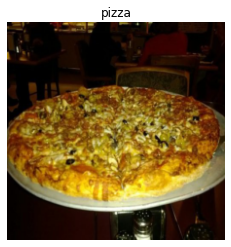

In [17]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [18]:
image.shape

torch.Size([3, 224, 224])

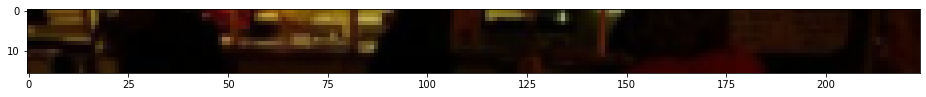

In [19]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # color channels last

# Index to plot the top row of pixels
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

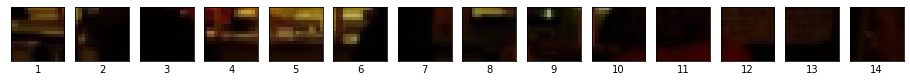

In [20]:
# Plot top row as patches
img_size = width
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image must be divisible by patch_size'

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # 1 column per patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)
)

# Iterate through number of patches in top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'pizza')

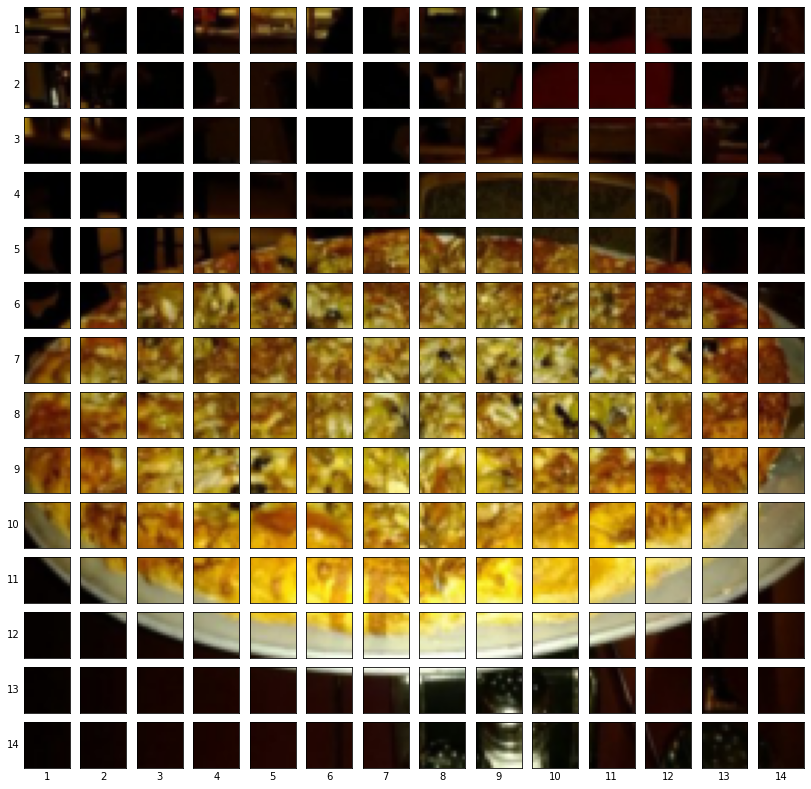

In [21]:
# Setup code to plot whole image as patches:
img_size = width
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image must be divisible by patch_size'
print(f'Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches ** 2}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fix, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through hieght and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # plot the permuted image on the different axes
    axs[i][j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # all channels
    axs[i][j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i][j].set_xlabel(j+1)
                         
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].label_outer()
# title for the plot:
fig.suptitle(f'{class_names[label]}')



### 4.3 Creating image patches and turning them into patch embeddings

We create the image patches and embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [22]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)

from torch import nn

# set the patch size
patch_size = 16
channels = 3

# create a conv2d layer with hyperparameters from the vit paper
conv2d = nn.Conv2d(in_channels=channels,
                   out_channels=patch_size*patch_size*channels, # D size from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [23]:
# pass the image through the convolutional layer:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a batch dim so (batch_size, channels, height, width)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

We want to transform the feature_map_height and width into a single sequence.

Showing random convolutional feature maps from indexes: [292, 542, 74, 106, 514]


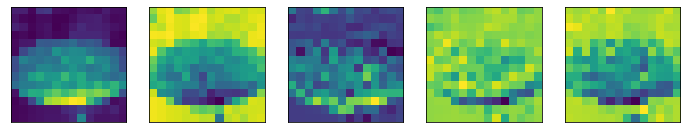

In [24]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, patch_size*patch_size*channels - 10), k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, : , :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, remove from grad tracking, switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [25]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 3.8860e-02,  6.5039e-02,  4.1525e-03,  1.1608e-01,  1.6486e-01,
            1.6248e-01,  9.2657e-03,  5.6859e-02,  6.0889e-02,  3.2353e-02,
           -3.1357e-03,  3.3505e-02,  8.7029e-03,  7.1577e-03],
          [ 5.8688e-02, -2.0819e-02, -1.1731e-02,  1.0336e-02,  6.6669e-03,
           -2.1622e-02, -3.2023e-03,  4.8032e-02,  4.6729e-02,  6.3827e-04,
            8.7540e-03, -6.4257e-03, -4.1841e-03, -4.5429e-03],
          [ 2.1213e-02,  1.2505e-03, -1.2027e-02,  1.8616e-02,  2.3419e-02,
           -1.9635e-02,  1.7587e-03,  3.7848e-02,  3.8175e-02,  3.4902e-02,
            3.9575e-02,  3.9640e-02,  5.4408e-02,  3.2254e-03],
          [ 6.5298e-03, -1.2377e-02, -1.8800e-02,  2.9800e-03,  1.8840e-02,
           -8.6948e-03,  1.0170e-02,  7.3305e-02,  1.1037e-01,  1.1526e-01,
            8.3701e-02,  2.1349e-02, -2.3421e-03, -8.1567e-03],
          [ 7.6544e-03, -1.5660e-03,  8.8147e-02,  2.1222e-01,  2.5526e-01,
            3.0682e-01,  2.6585e-01,  3.7934e-01,  2.9580e-0

In [26]:
m = nn.Flatten(start_dim=2, end_dim=3)
flattened = m(image_out_of_conv)
image_out_of_conv.shape, flattened.shape

(torch.Size([1, 768, 14, 14]), torch.Size([1, 768, 196]))

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence to satisfy the input criteria of the ViT Transformer Encoder.

In [27]:
print(f'{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)')


torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want (batch_size, number_of_patches, embedding_dim)

In [28]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flattened = flatten_layer(image_out_of_conv)
flattened.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


torch.Size([1, 196, 768])

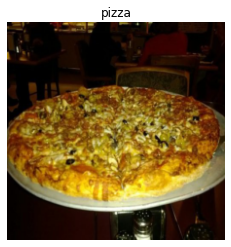

In [29]:
# put everthing together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')

# turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a batch dim so (batch_size, channels, height, width)
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
image_out_of_conv_flattened_permuted.shape

(-0.5, 195.5, 0.5, -0.5)

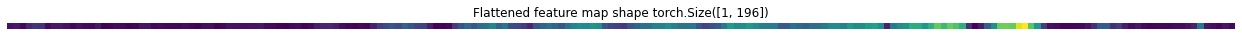

In [30]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape {single_flattened_feature_map.shape}')
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:

1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Creae a layer to flatten the feture maps of the output of the layer in 3.
5. Define a `forward()` method that defines the forward computation (pass through layer from 3 to 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [31]:
import torch
from torchvision.transforms import Compose
from torch import nn

# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size: int=16,
               embedding_dim:int=None):
    super().__init__()
    self.patch_size = patch_size
    if embedding_dim is None:
      embedding_dim = patch_size * patch_size * channels

    # 3. Create a layer to turn an image into embedded patches:
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim, # D size from table 1
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten the feature map outputs of conv2d
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    self.layers = Compose([
        self.patcher,
        self.flatten
    ])

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x: torch.Tensor):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f'Image size must be ' \
      f'divisible by patch size, image shape: {image_resolution}, ' \
      f'patch size: {self.patch_size}'
    
    # This is the dbourke stuff, but we can also just use the composition
    # of the individual layers as seen below
    # perform forward pass
    # x_patched = self.patcher(x)
    # x_flattened = self.flatten(x_patched)

    # Make sure the returned sequence embedding dimensions are in the
    # right order (batch_size, number_of_patches, embedding_dimension)
    # x_permuted = x_flattened.permute(0, 2, 1)
    # return x_permuted
    return self.layers(x).permute(0, 2, 1)

In [32]:
set_seeds()

# Create an instance of the patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=None, # PatchEmbedding figures it out
                          patch_size=16)

# pass a single image through patch embedding layer
print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # add batch dimension
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [33]:
patchify(image.unsqueeze(0)).shape

torch.Size([1, 196, 768])

In [34]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
bad_image_tensor = torch.randn(1, 3, 250, 250)
patchify(rand_image_tensor)
# patchify(bad_image_tensor) # expect this to assert

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [35]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [36]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [37]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension D
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # use torch.randn for reals
                           requires_grad=True) 
class_token.shape                           

torch.Size([1, 1, 768])

In [38]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(f'sequence of patch embeddings with class token prepend shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_paptches, embedding_dimension')

sequence of patch embeddings with class token prepend shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_paptches, embedding_dimension


In [39]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)
patchify(rand_image_tensor).shape

torch.Size([1, 196, 768])

### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and add them to the sequence of patch embeddings.

In [40]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [41]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size ** 2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, # should be randn here too
                                             number_of_patches + 1, # or patch_embedded_image_with_class_embedding.shape[-1]
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [42]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7874, 0.9667, 0.9137,  ..., 1.1368, 0.9657, 0.9732],
          [1.0523, 0.9380, 0.9464,  ..., 0.9799, 0.9814, 1.0528],
          ...,
          [1.0031, 0.9785, 0.9486,  ..., 1.0568, 0.9945, 1.0425],
          [0.8737, 0.9867, 0.9548,  ..., 1.0353, 0.9521, 0.9927],
          [0.9205, 0.9820, 0.9841,  ..., 1.0523, 0.9669, 1.0051]]],
        grad_fn=<AddBackward0>), torch.Size([1, 197, 768]))

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings. Now let's see it all in one cell.

In [43]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f'Image tensor shape: {image.shape}')
channels, height, width = image.shape
print(f'channels: {channels}, height: {height}, width: {width}')

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = channels,
                                       patch_size=patch_size,
                                       embedding_dim=None) # embedding_dim is 768 but is calculated for us from the channels and patch_size

# 5. Pass image input through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f'shape of patch layer output: {patch_embedding.shape}')

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]

# using nn.Parameter makes it learnable
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f'Class token embedding shape: {class_token.shape}')

# 7. Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding

print(f'Patch and position embeddiing shape: {patch_and_position_embedding.shape}')


Image tensor shape: torch.Size([3, 224, 224])
channels: 3, height: 224, width: 224
Input image shape: torch.Size([1, 3, 224, 224])
shape of patch layer output: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embeddiing shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

o Multihead self attention: which part of a sequence should pay the most attention to itself?
  * In out case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
o To replicate MSA in PyTorch we can use `torch.nn.MultiheadAttention()`
o LayerNorm = Make everything in the layer have the same mean and same standard deviation over the mini-batch for a layer. `torch.nn.LayerNorm`. Normalizes over the $D$ dimension, which is the embedding dimension here.
  * When we normalize along the embedding dimension it's like making all the stairs in a staircase the same size. (Unlike the Culver Steps).

In [44]:
from torch import nn

class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short).
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimensions) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from table 1 for ViT-Base
               attn_dropout:int=0): # used in every layer except qkv
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention layer (MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch first? Yes! (batch, number_of_patches, embedding_dimension)
  
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _weights = self.multihead_attn(query=x,
                                                key=x,
                                                value=x,
                                                need_weights=False)
    return attn_output

In [45]:
# Create an instance MSA block

multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12,
    attn_dropout=0
)

# Pass the patch and position image embedding sequence through MSA block
# The shapes stays the same, but the neural network will learn a representation
# of the image.
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6.3 MLP Block Equation 3

* **MLP** = Two layers with a GELU non-linearity
  * MLP = broad term for a layer or a block with a series of layers.
* Layers can mean: fully-connected, dense, linear, feed-forward. All are similar names for the same thing. In PyTorch they're often called `torch.nn.Linear()` and in TensorFlow `tf.keras.layers.Dense()`
* GELU (Gaussian Error Linear Unit). 

  $\text{GELU}\left(x\right) = x{P}\left(X\leq{x}\right) = x\Phi\left(x\right) = x \cdot \frac{1}{2}\left[1 + \text{erf}(x/\sqrt{2})\right]$
  https://pytorch.org/docs/stable/generated/torch.nn.GELU.html

* **Dropout** Value available in Table 3

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> non-linear -> dropout
```


In [46]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072, # MLP size in table 1
               dropout=0.1):
    super().__init__()

    # Create the norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dimension,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    return self.mlp(self.layer_norm(x))

In [47]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Test that we have the shapes correct:
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape: {patched_image_through_msa_block.shape}, MLP block output_shape: {patched_image_through_mlp_block.shape}') # should be same as input shape

Input shape: torch.Size([1, 197, 768]), MLP block output_shape: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (Equation 2) and MLP (Equation 3), adding in the residual connections.

* Encoder - turn a sequence into learnable representation
* Decoder - go from learned representation back to some sort of sequence
* Residiual connections - add a layer(s) input to its subsequent output; enables the creation of deeper networks and keeps the weights from getting too small.

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_Block_output + MSA_block_output + x_input] -> ...
```

In [48]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0.0):
    super().__init__()
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x
    # msa_output = self.msa_block(x)
    # mlp_output = self.mlp_block(msa_output + x)
    # return mlp_output + msa_output + x


In [49]:
transformer_encoder = TransformerEncoderBlock()
transformer_encoder(patch_and_position_embedding)

tensor([[[2.0972, 2.3148, 2.0988,  ..., 1.4165, 1.4785, 1.8266],
         [0.6489, 1.5019, 1.0616,  ..., 0.5339, 0.4708, 0.7842],
         [1.0610, 1.2736, 0.9201,  ..., 0.6063, 0.5563, 0.8022],
         ...,
         [0.9193, 1.3981, 0.9479,  ..., 0.4012, 0.4239, 0.9020],
         [1.0240, 1.5484, 0.8446,  ..., 0.3958, 0.3464, 0.8139],
         [1.0736, 1.3534, 1.1716,  ..., 0.4919, 0.4161, 0.7580]]],
       grad_fn=<AddBackward0>)

In [50]:
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dim
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a custom Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready-to-use encoder layers.

We can create a Transformer Encoder layer with pure PyTorch layers.

In [51]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding_dim
                                                             nhead=12,
                                                             dim_feedforward=3072, # mlp size
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [52]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dim
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time re-creating the transformer encoder when we could have just made it with a single PyTorch layer?

Practice!

What are the benefits of using a pre-built PyTorch layer?

* Less prone to errors (lots of testing)
* Potential performance optimizations (some constraints on configuration)

`torch.nn.TransformerEncoder` takes a `TransformerEncoderLayer` and a count, to auto-stack the layers.

## 8. Putting it all together to create ViT

In [53]:
# Create a ViT class
from torchvision.ops import MLP
import torch
from torch import nn

class Vit(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3, image size (square image)
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers=12,
               num_heads:int=12,
               embedding_dim:int=None,
               mlp_size:int=3072,
               attn_dropout:float=0.0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=1000,
               use_pytorch_transformer=False): # original ViT has 1000 classes
    super().__init__()
    if not embedding_dim:
      embedding_dim = patch_size * patch_size * in_channels
    self.embedding_dim = embedding_dim

    # make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f'Image size must be divisible by patch_size, image: {img_size}, patch size: {patch_size}'

    # Calculate the number of patches
    self.num_patches = (img_size * img_size) // (patch_size ** 2)

    # Create learnable class embedding (front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    
    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim),
                                           requires_grad=True)
    
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer (TODO(gavin): put the above layers inside PatchEmbedding)
    self.patch_embedding_layer = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)

    # Create the Transformer Encoder block
    if use_pytorch_transformer:
      self.transformer_encoder = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=embedding_dim, # embedding_dim
                                  nhead=num_heads,
                                  dim_feedforward=mlp_size, # mlp size
                                  dropout=attn_dropout,
                                  activation="gelu",
                                  batch_first=True,
                                  norm_first=True)
      for _ in range(num_transformer_layers)])
    else:    
      # By default, use the transformer encoder we've been building:
      self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                num_heads=num_heads,
                                mlp_size=mlp_size,
                                mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )


  def forward(self, x):
    # get the batch size
    batch_size = x.shape[0]

    # Create the class token embedding and expand it
    # to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means infer the dimension

    x = self.patch_embedding_layer(x)

    # Concat class token embedding and patch embedding
    x = torch.cat((class_token, x), dim=1)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embeddings
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to transformer encoder (eq 2 & 3)
    x = self.transformer_encoder(x) #

    # Put 0th index logit through classifier (eq 4)
    x = self.classifier(x[:, 0])

    return x

In [54]:
set_seeds()
random_image_tensor = torch.randn(1, 3, 224, 224)
vit1k = Vit()
print(f'random_image_tensor_shape after vit:{vit1k(random_image_tensor).shape}')
vit = Vit(num_classes=3)
print(f'image input with 3 classes: {vit(image.unsqueeze(0))}')

random_image_tensor_shape after vit:torch.Size([1, 1000])
image input with 3 classes: tensor([[ 0.5655, -0.5556, -0.8744]], grad_fn=<AddmmBackward0>)


### 8.1 Getting a visual summary of our ViT model

In [55]:
from torchinfo import summary

# Get a summary using torchinfo.summary
from timeit import default_timer as timer

start_time_pytorch = timer()
pytorch_summary = summary(model=Vit(num_classes=len(class_names), use_pytorch_transformer=True),
        input_size=(32, 3, 224, 224), # batch_size, channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])
end_time_pytorch = timer()

start_time = timer()
non_pytorch_summary = summary(model=Vit(num_classes=len(class_names), use_pytorch_transformer=False),
        input_size=(32, 3, 224, 224), # batch_size, channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])
end_time = timer()

print(f'[INFO] non-pytorch time: {end_time-start_time:.3f}seconds')
print(f'[INFO] pytorch time: {end_time_pytorch-start_time_pytorch:.3f}seconds')
print(f'summary for didactic model:\n{non_pytorch_summary}')

[INFO] non-pytorch time: 1.050seconds
[INFO] pytorch time: 4.053seconds
summary for didactic model:
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Vit (Vit)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding_layer)                     [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   T

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, let's see how it performs on foodvision mini data!

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with a $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay is a regularization technique where a small penalty, usually the L2 norm of all the weights of the model, is added to the loss function.

Regularization technique = reduce overfitting.

Weight Decay, or Regularization, is a regularization technique applied to the weights of a neural network. We minimize a loss function compromising both the primary loss function and a penalty on the Norm of the weights: L n e w ( w ) = L o r i g i n a l ( w ) + λ w T w.

In [56]:
from torch.optim import Adam

opt = Adam(params=vit.parameters(),
           lr=1e-3,
           betas=(0.9, 0.999),
           weight_decay=0.1) # betas in paper are the same as the default (0.9, 0.999)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

Since it's multi-class we'll use `torch.nn.CrossEntropyLoss()`

(search for loss/criterion but assume cross-entropy in multiclass)


In [57]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [60]:
from going_modular.going_modular import engine

results = engine.train(model=vit,
                       optimizer=opt,
                       loss_fn=loss_fn,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10, # try 100, but the results are still bad
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3127 | train_acc: 0.4102 | test_loss: 2.0521 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6953 | train_acc: 0.2930 | test_loss: 1.4583 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4340 | train_acc: 0.3203 | test_loss: 1.3252 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.4351 | train_acc: 0.3711 | test_loss: 1.0863 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.2599 | train_acc: 0.2734 | test_loss: 1.1775 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1152 | train_acc: 0.4258 | test_loss: 1.4123 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1864 | train_acc: 0.4062 | test_loss: 1.2523 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.2284 | train_acc: 0.2773 | test_loss: 1.1436 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1998 | train_acc: 0.2734 | test_loss: 1.1367 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1109 | train_acc: 0.4102 | test_loss: 1.6413 | test_acc: 0.2604


### 9.4 What our training setup is missing

* Not as much data (by orders of magnitude)
* Not as many epochs (but collab is too slowwww)
* Hyperparameters to prevent overfitting:
  * (heh, if we weren't underfitting so badly)
  * Gradient clipping - prevents gradients from getting too big
  * learning rate warmup - start with a low learning rate and increase to a base LR
  * learning rate decay - as your model gets closer to convergence, start to lower the learning rate.

Search "pytorch [technique name]" for implementation details.


### 9.5 Plotting loss curves for our model

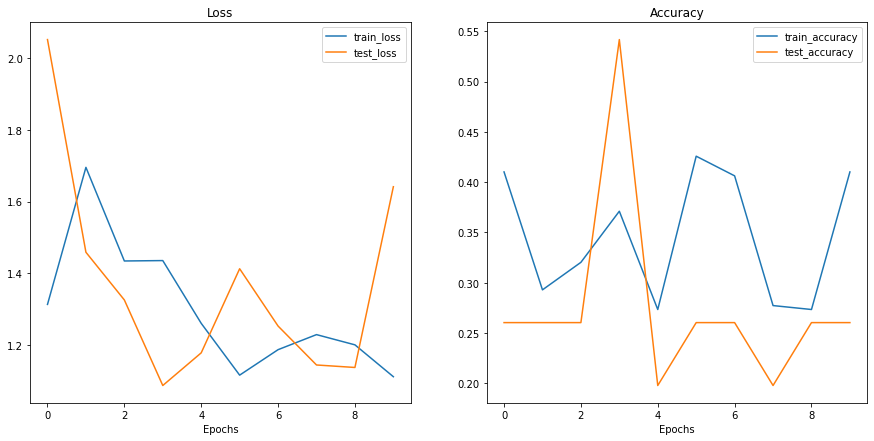

In [61]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning, if you can use a pretrained model from a large dataset on your own problem it's a good place to start.

If you can find a pretrained model and use transfer learning it often gives good results with little data.

**Why use a pretrained model?**

* Limited data
* Limited training resources
* Better results faster

In [63]:
# The following requires torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
device = 'cuda' if torch.cuda.is_available else 'cpu'

1.13.1+cu116
0.14.1+cu116


In [73]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head:
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # batch_size, channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [77]:
# Get automatic transforms from pretrained ViT weights::
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [86]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=BATCH_SIZE) # could set a higher batch size

## Train the pretrained ViT


In [91]:
from going_modular.going_modular import engine
from torch.optim import Adam

opt = Adam(params=pretrained_vit.parameters(),
           lr=1e-3,
           betas=(0.9, 0.999),
           weight_decay=0.1)

results = engine.train(model=pretrained_vit,
                       optimizer=opt,
                       loss_fn=loss_fn,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       epochs=10, 
                       device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0544 | train_acc: 1.0000 | test_loss: 0.1794 | test_acc: 0.9384
Epoch: 2 | train_loss: 0.0352 | train_acc: 1.0000 | test_loss: 0.1634 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.0347 | train_acc: 1.0000 | test_loss: 0.1756 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.0361 | train_acc: 1.0000 | test_loss: 0.1887 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.0323 | train_acc: 1.0000 | test_loss: 0.2004 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.0351 | train_acc: 1.0000 | test_loss: 0.1822 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.0342 | train_acc: 1.0000 | test_loss: 0.1666 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0353 | train_acc: 1.0000 | test_loss: 0.1775 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0483 | train_acc: 1.0000 | test_loss: 0.1937 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.0409 | train_acc: 1.0000 | test_loss: 0.2343 | test_acc: 0.9081
Epoch: 11 | train_loss: 0.0357 | train_acc: 1.0000 | test_loss: 0.2195 | test_acc: 0.9081
Epoch: 12 | train_l

### 10.5 Plot the loss curves of the pretrained ViT model

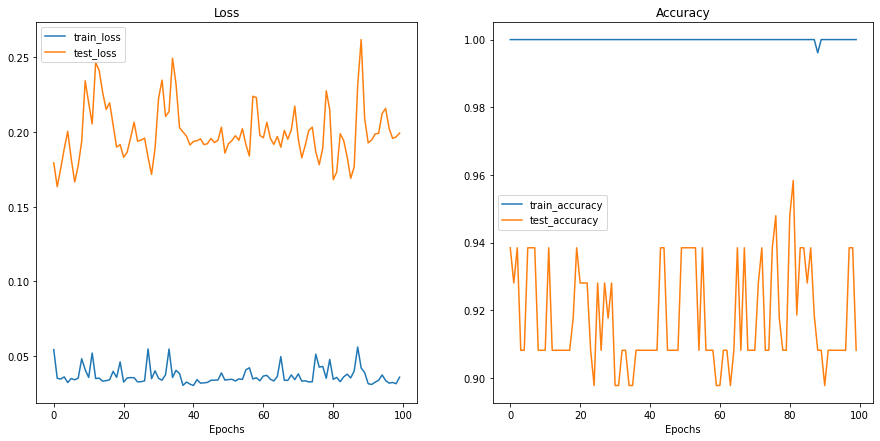

In [92]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### 10.6 Save our best performing ViT model

Check the filesize, because if we want to deploy a model to a mobile app, we may have limitations on the size of the model we can deploy.


In [96]:
from going_modular.going_modular.utils import save_model

save_model(pretrained_vit,
           target_dir='./models',
           model_name='pretrained.pth')

[INFO] Saving model to: models/pretrained.pth


In [97]:
!ls -l models/pretrained.pth

-rw-r--r-- 1 root root 343264159 Jan 29 22:56 models/pretrained.pth


In [98]:
# Gosh, that's a 327mb model, which is kinda giant

In [100]:
from pathlib import Path
# get the model size in bytes
pretrained_vit_model_size = Path('./models/pretrained.pth').stat().st_size // (1024 ** 2)
print(f'Pretrained vit feature extractor model size: {pretrained_vit_model_size}MB')

Pretrained vit feature extractor model size: 327MB


### 11. Predicting on a custom image


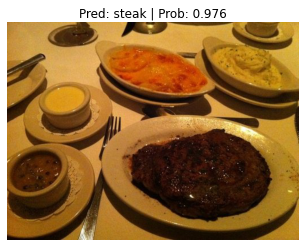

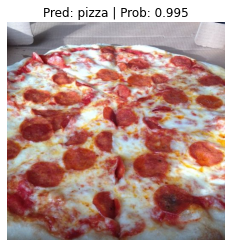

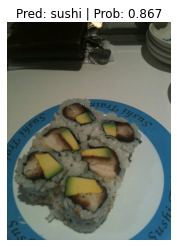

In [101]:
# Import function to make predictions on images and plot them.
from going_modular.going_modular.predictions import pred_and_plot_image


import random
num_images_to_plot = 3
test_image_path_list = list(Path('data/pizza_steak_sushi/test').glob('*/*.jpg'))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=pretrained_vit,
                      class_names=class_names,
                      image_size=(224, 224),
                      image_path=image_path)

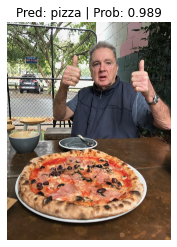

In [102]:
 pred_and_plot_image(model=pretrained_vit,
                      class_names=class_names,
                      image_size=(224, 224),
                      image_path='data/04-pizza-dad.jpeg')

# Main Takeaways

* Lots of papers coming out, but narrow things down to your own use case.
* Paper replicating is taking text/math/images and translating it to Python code, but these days sites like https://paperswithcode.com have both the paper and the code.
* Models may be layers stacked into a blocks, and blocks stacked into models.
* Is the better performance of a larger model really worth it for the use case?
